In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import gzip
import matplotlib.pyplot as plt

In [41]:
with gzip.open('human_comparison.msg.gz', 'r') as f:
    DATA = pd.read_msgpack(f)
    
with gzip.open('human_data_actions.msg.gz', 'r') as f:
    HUMAN_ACTIONS = pd.read_msgpack(f)

In [17]:
def grouped_barplot(plot_title, series_titles, group_titles, basis, *serieses):
    plt.figure(figsize=(16,8))
    # set width of bar
    COLORS = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3']
    barWidth = 1.0/(1 + len(serieses))

    # set height of bar
    bars1 = serieses[0]

    # Set position of bar on X axis
    positions = [ np.arange(len(bars1)) ]
    for _ in range(len(serieses) - 1):
        positions.append([x + barWidth for x in positions[-1] ])

    for i, (title, pos, series) in enumerate(zip(series_titles, positions, serieses)):
        plt.bar(pos, series, color=COLORS[i], width=barWidth, edgecolor='white', label=title)

    if basis is not None:
        plt.axhline(basis, color="gray")
        
    # Add xticks on the middle of the group bars
    plt.xlabel('group', fontweight='bold')
    plt.xticks([r + barWidth*(len(serieses) / 2.0 - 0.5) for r in range(len(bars1))], group_titles)

    # Create legend & Show graphic
    plt.title(plot_title)
    plt.legend()
    plt.show()

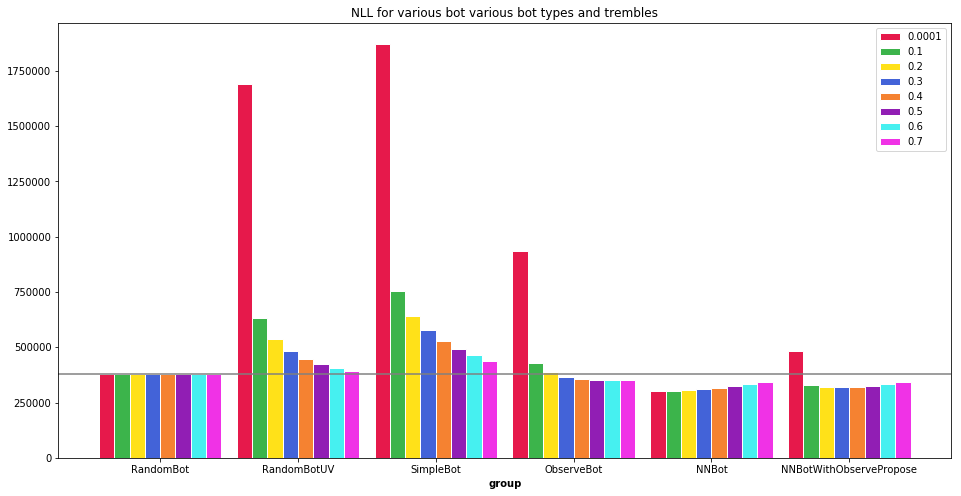

In [18]:
plot_title = "NLL for various bot types and trembles"
trembles = [0.0001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
bots = ["RandomBot", "RandomBotUV", "SimpleBot", "ObserveBot", "NNBot", "NNBotWithObservePropose"]
serieses = [ [ DATA[(DATA.bot == bot) & (DATA.trembling_hand_prob == p)].nll.sum() for bot in bots] for p in trembles ]
grouped_barplot(plot_title, trembles, bots, serieses[0][0], *serieses)

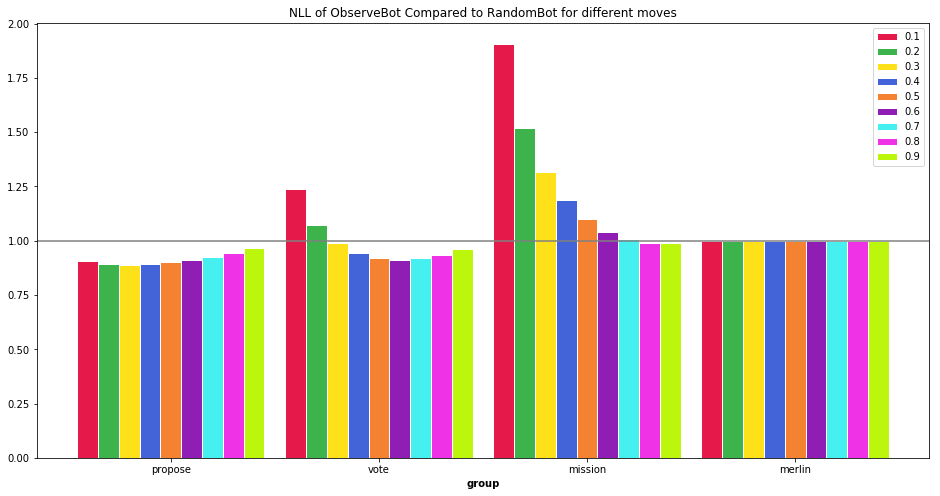

In [31]:
OB_DATA = DATA[DATA.bot == 'ObserveBot']
RAND_DATA = DATA[DATA.bot == 'RandomBot']
plot_title = "NLL of ObserveBot Compared to RandomBot for different moves"
trembles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
move_types = ["propose", "vote", "mission", "merlin"]
rand_perf = {
    typ: RAND_DATA[(RAND_DATA.type == typ) & (RAND_DATA.trembling_hand_prob == 0.1)].nll.sum()
    for typ in move_types
}
serieses = [
    [
        OB_DATA[(OB_DATA.type == typ) & (OB_DATA.trembling_hand_prob == p)].nll.sum()/rand_perf[typ]
        for typ in move_types
    ]
    for p in trembles
]
grouped_barplot(plot_title, trembles, move_types, 1.0, *serieses)

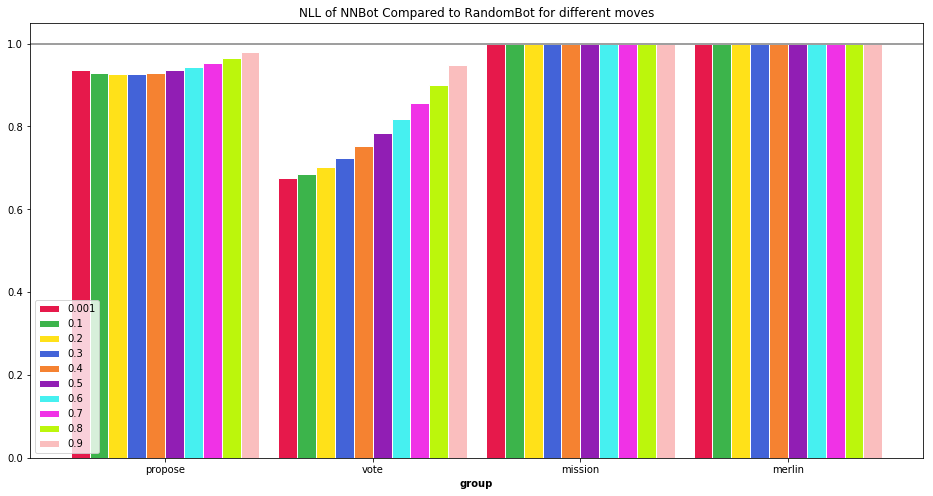

In [34]:
NN_DATA = DATA[DATA.bot == 'NNBot']
RAND_DATA = DATA[DATA.bot == 'RandomBot']
plot_title = "NLL of NNBot Compared to RandomBot for different moves"
trembles = [0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
move_types = ["propose", "vote", "mission", "merlin"]
rand_perf = {
    typ: RAND_DATA[(RAND_DATA.type == typ) & (RAND_DATA.trembling_hand_prob == 0.1)].nll.sum()
    for typ in move_types
}
serieses = [
    [
        NN_DATA[(NN_DATA.type == typ) & (NN_DATA.trembling_hand_prob == p)].nll.sum()/rand_perf[typ]
        for typ in move_types
    ]
    for p in trembles
]
grouped_barplot(plot_title, trembles, move_types, 1.0, *serieses)

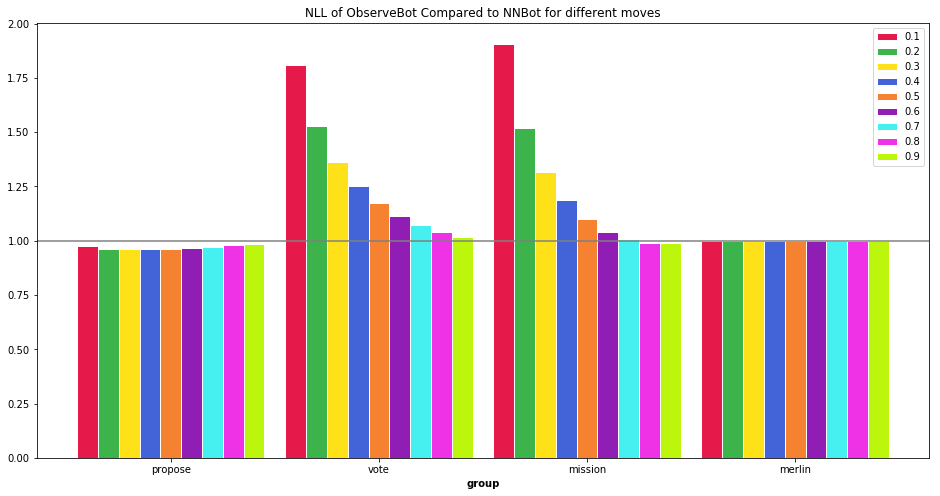

In [37]:
plot_title = "NLL of ObserveBot Compared to NNBot for different moves"
trembles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
move_types = ["propose", "vote", "mission", "merlin"]

serieses = [
    [
        (
            OB_DATA[(OB_DATA.type == typ) & (OB_DATA.trembling_hand_prob == p)].nll.sum() /
            NN_DATA[(NN_DATA.type == typ) & (NN_DATA.trembling_hand_prob == p)].nll.sum()
        )
        for typ in move_types
    ]
    for p in trembles
]
grouped_barplot(plot_title, trembles, move_types, 1.0, *serieses)

/Users/jserrino/.virtualenvs/battlefield/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


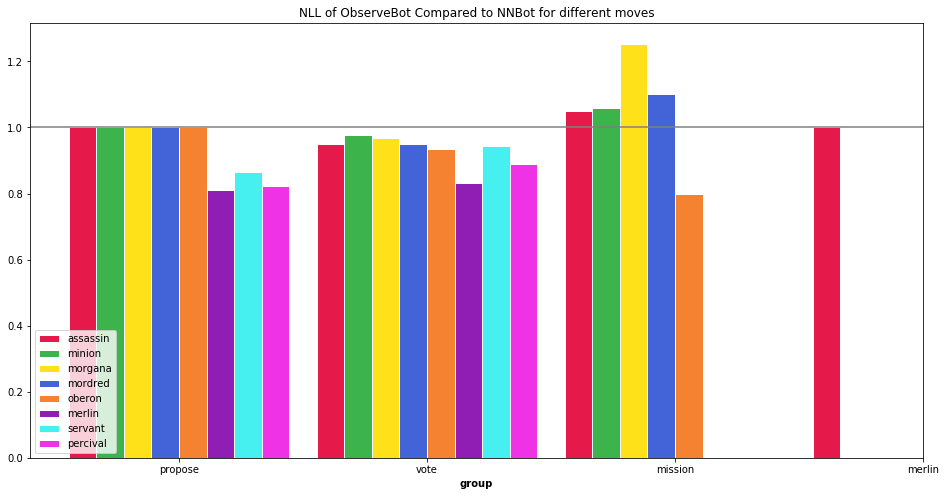

In [40]:
plot_title = "NLL of ObserveBot Compared to NNBot for different moves"
roles = ['assassin', 'minion', 'morgana', 'mordred', 'oberon', 'merlin', 'servant', 'percival']
move_types = ["propose", "vote", "mission", "merlin"]

serieses = [
    [
        (
            OB_DATA[(OB_DATA.role == role) & (OB_DATA.type == typ) & (OB_DATA.trembling_hand_prob == 0.5)].nll.sum() /
            RAND_DATA[(RAND_DATA.role == role) & (RAND_DATA.type == typ) & (RAND_DATA.trembling_hand_prob == 0.5)].nll.sum()
        )
        for typ in move_types
    ]
    for role in roles
]
grouped_barplot(plot_title, roles, move_types, 1.0, *serieses)